# Gaussianzation ENUSA data

In [104]:
import os
import sys
import math
import time
import random
import tempfile
from functools import reduce
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax
import scipy.io

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence
from flows.flows import Flow, AffineConstantLayer, NvpCouplingLayer, PlanarLayer

In [90]:
%matplotlib inline
plt.ioff()

In [91]:
PI = torch.Tensor([math.pi])
dev = torch.device('cpu')

In [92]:
data_path = os.path.join('..', 'enusa')

### Read DATA

In [43]:
mat = scipy.io.loadmat(os.path.join(data_path, 'datos.mat'))

In [44]:
# Nombres de variables

names6 = ['PH', 'dLetdown', 'H2', 'co58', 'co60', 'cr51']
names7 = ['PH', 'dLetdown', 'H2', 'Zn', 'co58', 'co60', 'cr51']

## Funciones auxiliares:

In [45]:
def refill_data(D, G):
    D[:, 1:3] = G[:, :2]
    D[:, 4:-1] = G[:, 2:]
    
    return D

In [46]:
def save_model(name, model, moments, path='.'):
    full_path = os.path.join(path, name)
    
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    # Save pytorch model
    torch.save(model.state_dict(), os.path.join(full_path, 'model.pth'))
    
    # Save normalization constants
    mu, sigma = moments
    np.save(os.path.join(full_path, 'mu.npy'), mu)
    np.save(os.path.join(full_path, 'sigma.npy'), sigma)

In [47]:
def plot_histograms(G):
    if G.shape[1] == 7:
        
        fig, ax = plt.subplots(2, 4, figsize=(16, 12))
        for i in range(7):
            ax[i//4, i%4].hist(G[:, i], 50, range=[-3, 3], density=True)
            ax[i//4, i%4].set_title(names7[i])
            
        ax[1, 3].axis('off')
        plt.show()
    else:
        fig, ax = plt.subplots(2, 3, figsize=(16, 12))

        for i in range(6):
            ax[i//3, i%3].hist(G[:, i], 50, range=[-3, 3], density=True)
            ax[i//3, i%3].set_title(names6[i])

        plt.show()

In [48]:
def preprocess_data(D):
    X = np.hstack((D[:, 1:3], D[:, 4:-1]))
    
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    return (X- mu)/sigma, mu, sigma

In [49]:
def train_flow(model, X, epochs=100000):
    model = model.to(dev, non_blocking=True)

    # Instantiate optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    loss = []
    logpz = []
    logdet = []

    # Train loop
    t0 = time.time()
    for e in range(epochs):

        cum_loss = torch.zeros(1, device=dev)
        cum_logdet = torch.zeros(1, device=dev)
        cum_logprior = torch.zeros(1, device=dev)

        optimizer.zero_grad()

        preds, _logdet = model(X)

        _logdet = torch.mean(_logdet)
        _logpz = torch.mean(-0.5 * (torch.log(2*PI)*dim + torch.sum(torch.pow(preds[-1], 2), dim=1)))
        _loss = -_logpz - _logdet

        _loss.backward()
        optimizer.step()

        loss.append(_loss.item())
        logpz.append(_logpz.item())
        logdet.append(_logdet.item())
        
        if e%100 == 99:
            print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1], logdet[-1]), end="\r")

    return model, [loss, logpz, logdet]

## Central 1:

In [105]:
# Datos de la primera central
D1 = mat['datosF'][0, 0]

X1, mu1, sigma1 = preprocess_data(D1)

dim = X1.shape[1]

# Convertir a pytorch
X1_torch = torch.as_tensor(X1, dtype=torch.float).to(dev)

### Gaussianizar con un flow

In [106]:
epochs = 40000
model1 = Flow([NvpCouplingLayer(dim, hidden_size=[5, 5]) for _ in range(10)])

In [107]:
model1, h1 = train_flow(model1, X1_torch, epochs=epochs)

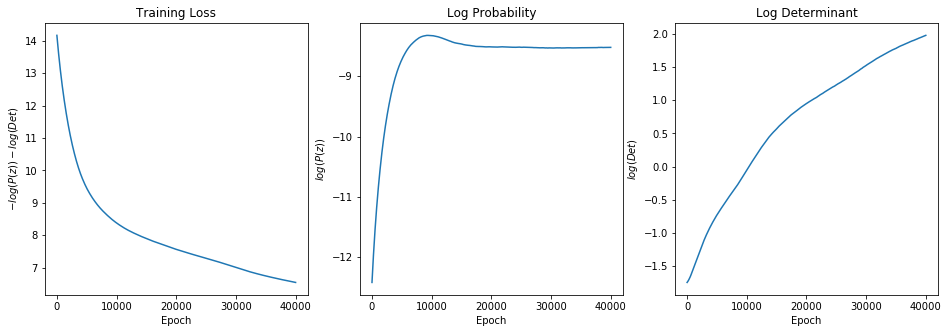

In [108]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(h1[0])
ax[1].plot(h1[1])
ax[2].plot(h1[2])


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

### Estimated pdf of each dimension

In [109]:
G1 = model1(X1_torch)[0][-1].detach().cpu().numpy()

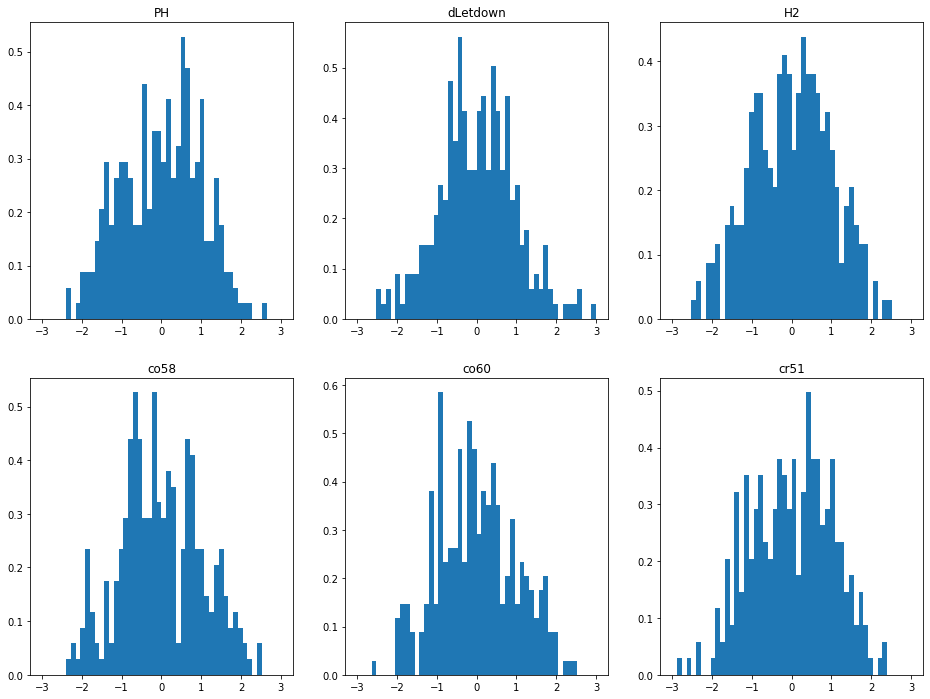

In [110]:
plot_histograms(G1)

In [116]:
save_model('central1', model1, [mu1, sigma1], path=data_path)

## Central 2:

In [166]:
# Datos de la segunda central
D2 = mat['datosF'][0, 1]

X2, mu2, sigma2 = preprocess_data(D2)

dim = X2.shape[1]

# Convertir a pytorch
X2_torch = torch.as_tensor(X2, dtype=torch.float).to(dev)

In [167]:
model2 = Flow([NvpCouplingLayer(dim, hidden_size=[5, 5]) for _ in range(10)])

In [168]:
model2, h2 = train_flow(model2, X2_torch, epochs=20000)

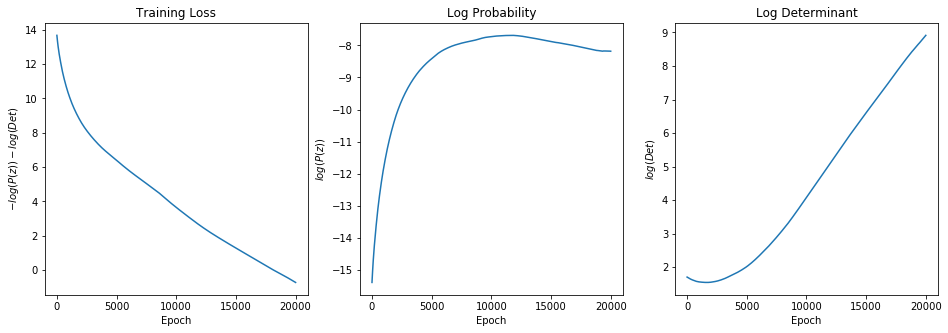

In [169]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(h2[0])
ax[1].plot(h2[1])
ax[2].plot(h2[2])


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

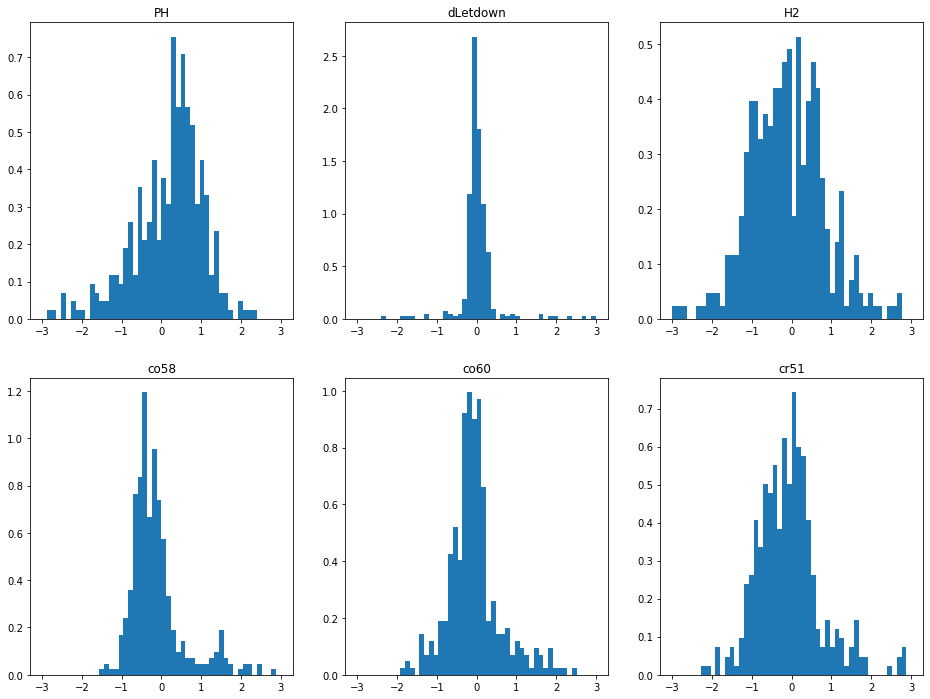

In [170]:
G2 = model2(X2_torch)[0][-1].detach().cpu().numpy()
plot_histograms(G2)

In [171]:
save_model('central2', model2, [mu2, sigma2], path=data_path)

## Central 3:

In [22]:
# Datos de la segunda central
D3 = mat['datosF'][0, 2]

X3, mu3, sigma3 = preprocess_data(D3)

dim = X3.shape[1]

# Convertir a pytorch
X3_torch = torch.as_tensor(X3, dtype=torch.float).to(dev)

In [23]:
model3 = Flow([NvpCouplingLayer(dim, hidden_size=[5, 5]) for _ in range(10)])
model3, h3 = train_flow(model3, X3_torch, epochs=epochs)

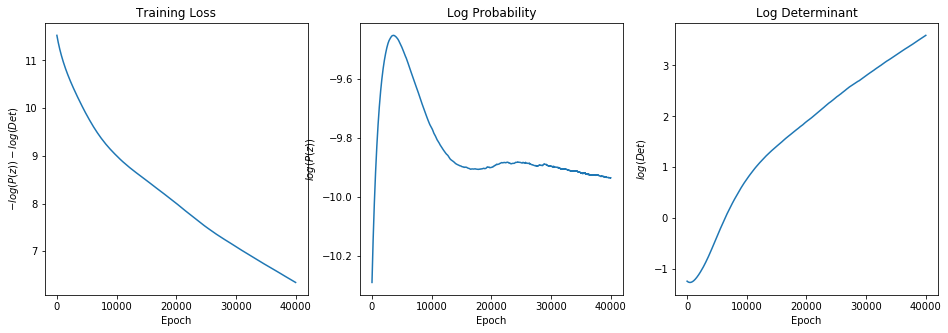

In [24]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(h3[0])
ax[1].plot(h3[1])
ax[2].plot(h3[2])


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

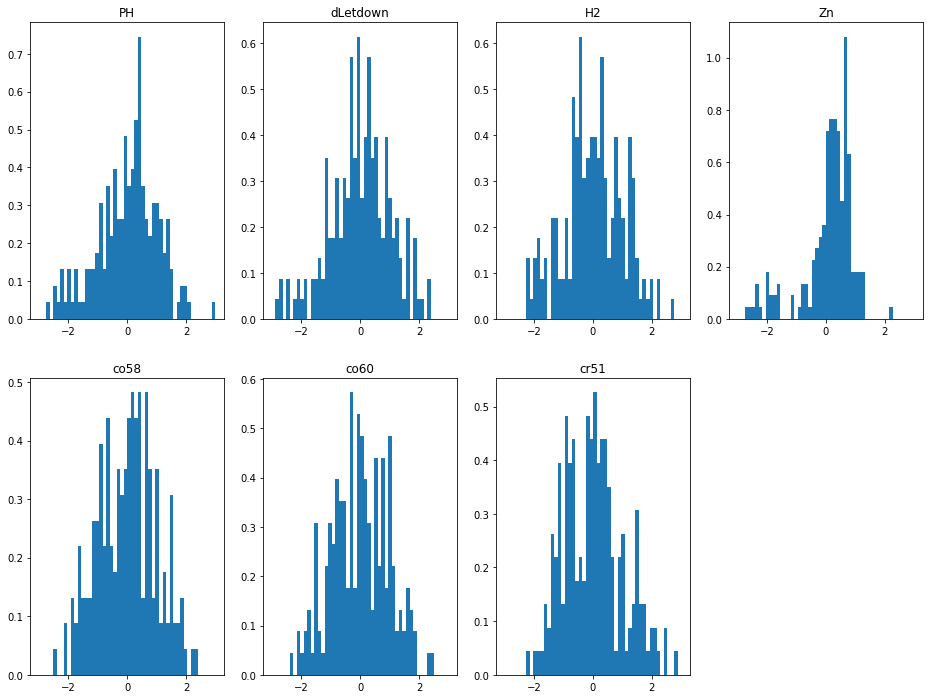

In [45]:
G3 = model3(X3_torch)[0][-1].detach().cpu().numpy()
plot_histograms(G3)

In [54]:
save_model('central3', model3, [mu3, sigma3], path=data_path)

## Central 4:

In [35]:
# Datos de la cuarta central
D4 = mat['datosF'][0, 3]

X4, mu4, sigma4 = preprocess_data(D4)

dim = X4.shape[1]

# Convertir a pytorch
X4_torch = torch.as_tensor(X4, dtype=torch.float).to(dev)

In [38]:
model4 = Flow([NvpCouplingLayer(dim, hidden_size=[5, 5]) for _ in range(10)])
model4, h4 = train_flow(model4, X4_torch, epochs=20000)

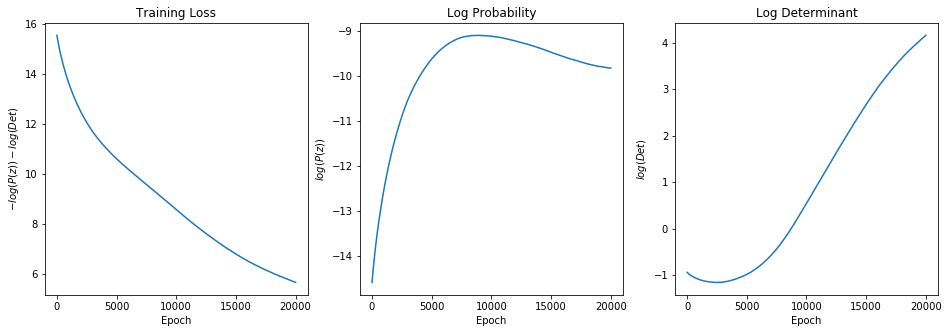

In [39]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(h4[0])
ax[1].plot(h4[1])
ax[2].plot(h4[2])


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

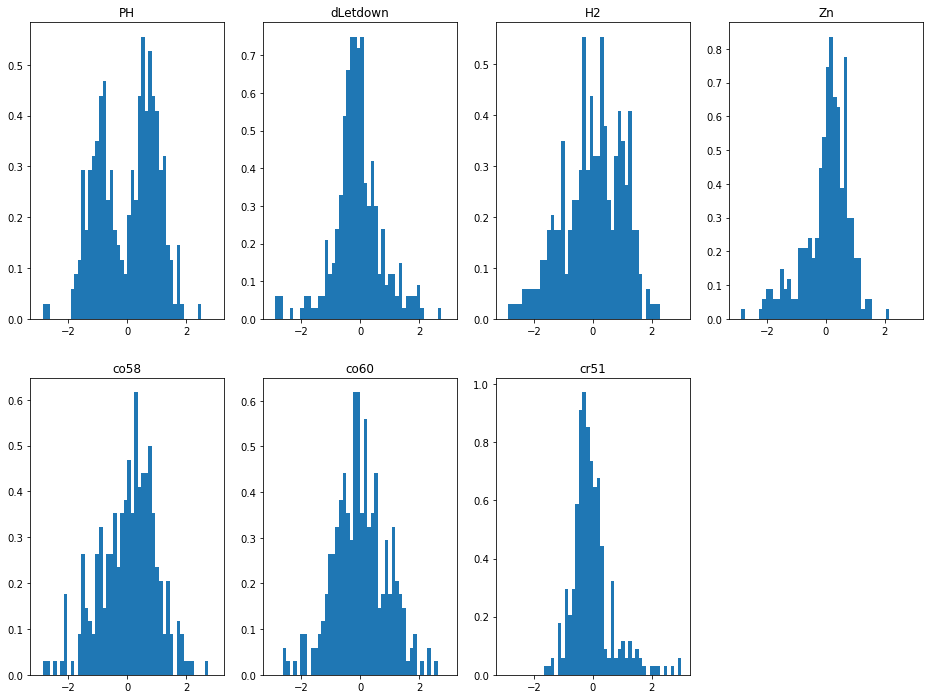

In [46]:
G4 = model4(X4_torch)[0][-1].detach().cpu().numpy()
plot_histograms(G4)

In [55]:
save_model('central4', model4, [mu4, sigma4], path=data_path)

## Central 5:

In [30]:
# Datos de la quinta central
D5 = mat['datosF'][0, 4]

X5, mu5, sigma5 = preprocess_data(D5)

dim = X5.shape[1]

# Convertir a pytorch
X5_torch = torch.as_tensor(X5, dtype=torch.float).to(dev)

In [31]:
model5 = Flow([NvpCouplingLayer(dim, hidden_size=[5, 5]) for _ in range(10)])
model5, h5 = train_flow(model5, X5_torch, epochs=epochs)

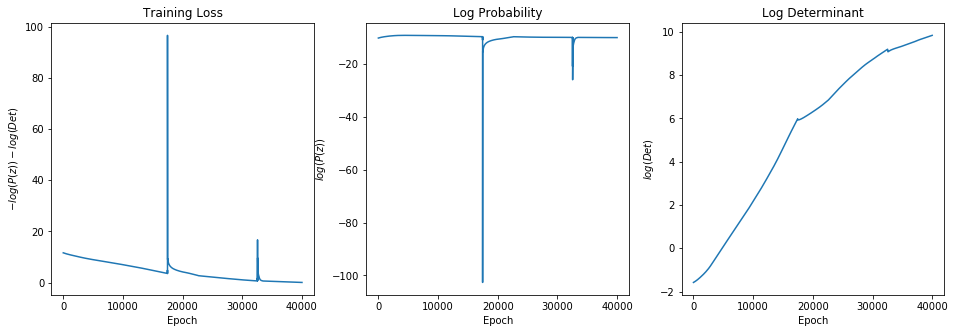

In [32]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(h5[0])
ax[1].plot(h5[1])
ax[2].plot(h5[2])


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

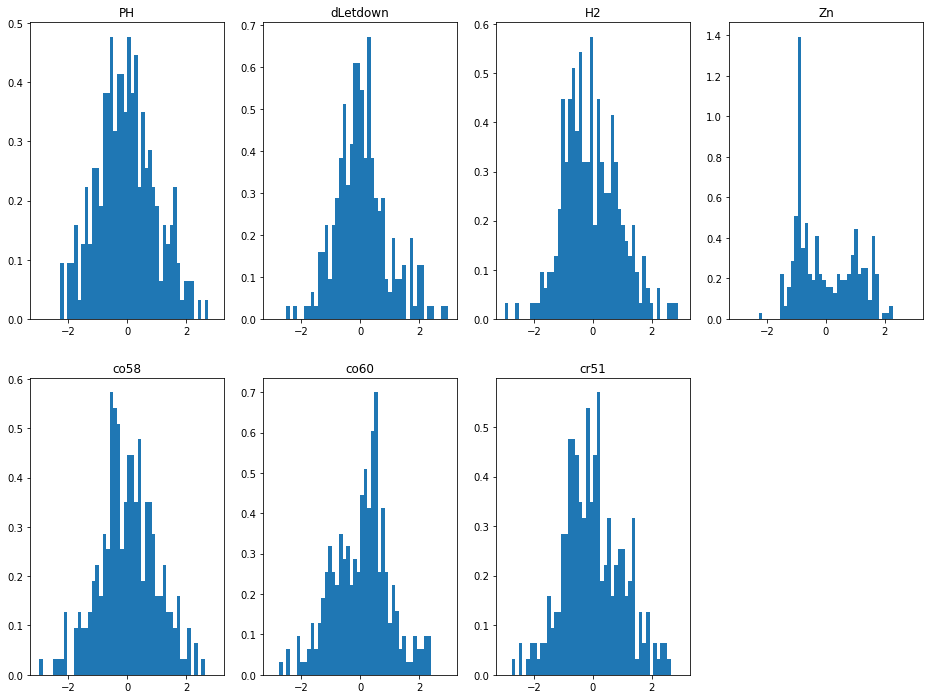

In [47]:
G5 = model5(X5_torch)[0][-1].detach().cpu().numpy()
plot_histograms(G5)

In [56]:
save_model('central5', model5, [mu5, sigma5], path=data_path)

## Generate .mat

In [48]:
mat['datosF'][0, 0] = refill_data(mat['datosF'][0, 0], G1)
mat['datosF'][0, 1] = refill_data(mat['datosF'][0, 1], G2)
mat['datosF'][0, 2] = refill_data(mat['datosF'][0, 2], G3)
mat['datosF'][0, 3] = refill_data(mat['datosF'][0, 3], G4)
mat['datosF'][0, 4] = refill_data(mat['datosF'][0, 4], G5)

In [58]:
scipy.io.savemat(os.path.join(data_path, 'datos_gaussianizados.mat'), mat)

# Degaussianize

In [172]:
Gdata = scipy.io.loadmat(os.path.join(data_path, 'Resultados_media.mat'))

## Funciones auxiliares

In [173]:
def get_model(path, dim):
    model = Flow([NvpCouplingLayer(dim, hidden_size=[5, 5]) for _ in range(10)])
    model.load_state_dict(torch.load(os.path.join(path, 'model.pth')))
    model.eval()
    
    mu = np.load(os.path.join(path, 'mu.npy'))
    sigma = np.load(os.path.join(path, 'sigma.npy'))
    
    return model, [mu, sigma]

In [174]:
def degaussianize(G, model, moments):
    
    Z = np.hstack((G[:, 1:3], G[:, 4:-1]))
    
    Z_torch = torch.as_tensor(Z, dtype=torch.float).to(dev)
    X_torch, _ = model.backward(Z_torch)
    X = X_torch[-1].detach().cpu().numpy()
    
    
    mu, sigma = moments
    
    X = X*sigma + mu
    
    G[:, 1:3] = X[:, :2]
    G[:, 4:-1] = X[:, 2:]
    
    return G

In [175]:
for c in range(5):
    dim = Gdata['Resultados_media'][c, 0].shape[1] - 3
    
    model, moments = get_model(os.path.join(data_path, 'central{:d}'.format(c+1)), dim)
    print('Procesando central{:d}'.format(c+1))
    for d in range(6):
        if 5 > Gdata['Resultados_media'][c, d].shape[1]:
            continue
        print('\t Dataset: {:d}'.format(d+1))
        Gdata['Resultados_media'][c, d] = degaussianize(Gdata['Resultados_media'][c, d], model, moments)
        
        if np.isnan(Gdata['Resultados_media'][c, d]).any():
            print('NaN-Values!')

Procesando central1
	 Dataset: 1
	 Dataset: 2
	 Dataset: 3
	 Dataset: 4
	 Dataset: 5
Procesando central2
	 Dataset: 1
	 Dataset: 2
	 Dataset: 3
	 Dataset: 4
	 Dataset: 5
	 Dataset: 6
Procesando central3
	 Dataset: 1
	 Dataset: 2
	 Dataset: 3
Procesando central4
	 Dataset: 1
	 Dataset: 2
	 Dataset: 3
	 Dataset: 4
Procesando central5
	 Dataset: 1
	 Dataset: 2
	 Dataset: 3
	 Dataset: 4


In [124]:
np.isnan(Gdata['Resultados_media'][0, 0]).any()

False

In [103]:
scipy.io.savemat(os.path.join(data_path, 'datos_degaussianizados.mat'), Gdata)